# Neural Machine Translation using LSTMs
Download the dataset from [this link](http://d2l-data.s3-accelerate.amazonaws.com/fra-eng.zip)

<img src="images/Training_NMT.png">

<img src="images/NMT.png">

In [1]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
from tqdm import tqdm

In [39]:
batch_size = 128  # batch size for training.
epochs = 100  # number of epochs to train for.
latent_dim = 256  # latent dimensionality of the encoding space.
num_samples = 10000  # number of samples to train on.
data_path = 'fra-eng/fra.txt' # path to the data txt file on disk.

In [40]:
# vectorize the data

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

In [41]:
print("First 5 lines:", lines[:5])
print("Input and target text of the first line:", lines[0].split('\t'))

First 5 lines: ['Go.\tVa !', 'Hi.\tSalut !', 'Run!\tCours\u202f!', 'Run!\tCourez\u202f!', 'Who?\tQui ?']
Input and target text of the first line: ['Go.', 'Va !']


In [42]:
for line in tqdm(lines[:num_samples]):
    try:
        input_text, target_text = line.split('\t')
        target_text = '\t' + target_text + '\n' # \t as the start sequence character and \n as end sequence character

        input_texts.append(input_text)
        target_texts.append(target_text)

        for char in input_text:
            if char not in input_characters:
                input_characters.add(char)

        for char in target_text:
            if char not in target_characters:
                target_characters.add(char)
    except:
        print(line)

100%|██████████| 10000/10000 [00:00<00:00, 256797.79it/s]


In [43]:
print("First 5 input texts:", input_texts[:5])
print("First 5 target texts:", target_texts[:5])
print("Input characters:", input_characters)
print("Output characters:", target_characters)

First 5 input texts: ['Go.', 'Hi.', 'Run!', 'Run!', 'Who?']
First 5 target texts: ['\tVa !\n', '\tSalut !\n', '\tCours\u202f!\n', '\tCourez\u202f!\n', '\tQui ?\n']
Input characters: {'H', 'v', ' ', '2', '%', 'e', 'A', 'J', 'i', 'K', 'M', 'k', 'E', '5', '3', 'f', ':', '0', 'V', 's', '&', 'O', 'Y', 'N', 'u', 'F', 'I', 'j', '6', 'B', 'G', 'm', '$', 'q', 'o', 'b', "'", '?', 'h', '!', '1', 'L', 'T', 'P', 'y', 'Q', 'r', 'l', 'U', 'S', 'C', '8', 'R', 't', 'g', 'x', '-', 'c', 'a', 'D', 'W', ',', '.', 'd', '9', '7', 'n', 'p', 'z', 'w'}
Output characters: {'2', 'ê', '%', 'A', 'J', 'f', 'ë', '&', 'N', '(', 'u', 'j', 'o', '?', '!', 'L', 'û', 'ù', 'x', ',', '.', '»', 'n', 'z', 'è', '’', 'ï', '0', '\n', 'Y', 'B', 'q', 'b', '1', 'œ', 'P', 'S', '8', 'R', '-', 'D', 'd', 'p', 'v', 'e', 'i', 'M', 'K', 'V', ':', 's', 'â', 'O', 'G', 'm', '$', '\xa0', "'", 'h', 'é', 'T', 'y', 'î', 'l', 'U', 'C', 'à', '\t', 'H', ' ', '\u2009', '5', 'E', 'k', '3', ')', 'I', 'F', 'Ç', '\u202f', 'ç', 'ô', 'Q', 'Ê', 'r', 'É', 't

In [44]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [45]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [46]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [47]:
print("Input token index:", input_token_index)
print("Target token index:", target_token_index)

Input token index: {' ': 0, '!': 1, '$': 2, '%': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '0': 9, '1': 10, '2': 11, '3': 12, '5': 13, '6': 14, '7': 15, '8': 16, '9': 17, ':': 18, '?': 19, 'A': 20, 'B': 21, 'C': 22, 'D': 23, 'E': 24, 'F': 25, 'G': 26, 'H': 27, 'I': 28, 'J': 29, 'K': 30, 'L': 31, 'M': 32, 'N': 33, 'O': 34, 'P': 35, 'Q': 36, 'R': 37, 'S': 38, 'T': 39, 'U': 40, 'V': 41, 'W': 42, 'Y': 43, 'a': 44, 'b': 45, 'c': 46, 'd': 47, 'e': 48, 'f': 49, 'g': 50, 'h': 51, 'i': 52, 'j': 53, 'k': 54, 'l': 55, 'm': 56, 'n': 57, 'o': 58, 'p': 59, 'q': 60, 'r': 61, 's': 62, 't': 63, 'u': 64, 'v': 65, 'w': 66, 'x': 67, 'y': 68, 'z': 69}
Target token index: {'\t': 0, '\n': 1, ' ': 2, '!': 3, '$': 4, '%': 5, '&': 6, "'": 7, '(': 8, ')': 9, ',': 10, '-': 11, '.': 12, '0': 13, '1': 14, '2': 15, '3': 16, '5': 17, '8': 18, '9': 19, ':': 20, '?': 21, 'A': 22, 'B': 23, 'C': 24, 'D': 25, 'E': 26, 'F': 27, 'G': 28, 'H': 29, 'I': 30, 'J': 31, 'K': 32, 'L': 33, 'M': 34, 'N': 35, 'O': 36, 'P': 37, 'Q': 

In [48]:
"""Turn the sentences into 3 Numpy arrays, encoder_input_data, decoder_input_data, decoder_target_data:

encoder_input_data is a 3D array of shape (num_pairs, max_english_sentence_length, num_english_characters) containing a one-hot vectorization of the English sentences
decoder_input_data is a 3D array of shape (num_pairs, max_french_sentence_length, num_french_characters) containing a one-hot vectorization of the French sentences
decoder_target_data is the same as decoder_input_data but offset by one timestep. decoder_target_data[:, t, :] will be the same as decoder_input_data[:, t + 1, :]
"""

# the one-hot encoded vectors for each sample/input text for each char in the sequence
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens),dtype='float32') # input sentence to encoder
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32') # input sentence to decoder
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32') # expected output sentence of decoder


In [49]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1. # pads the end of the encoder_input_data sequences with the one-hot encoding vector for the space character (' '). It ensures that the input sequences have a consistent length, and the LSTM model can process sequences of the same length during training
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1. # <Start/\t> Jerusalem is the eternal capital of Palestine
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1. # Jerusalem is the eternal capital of Palestine <END/\n>
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1. # padding with space character
    decoder_target_data[i, t:, target_token_index[' ']] = 1. # padding with space character

In [64]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs) # output sequence at each time step, hidden state at the last time step, cell state at the last time step
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [65]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [66]:
# Train a basic LSTM-based Seq2Seq model to predict decoder_target_data given encoder_input_data and decoder_input_data

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

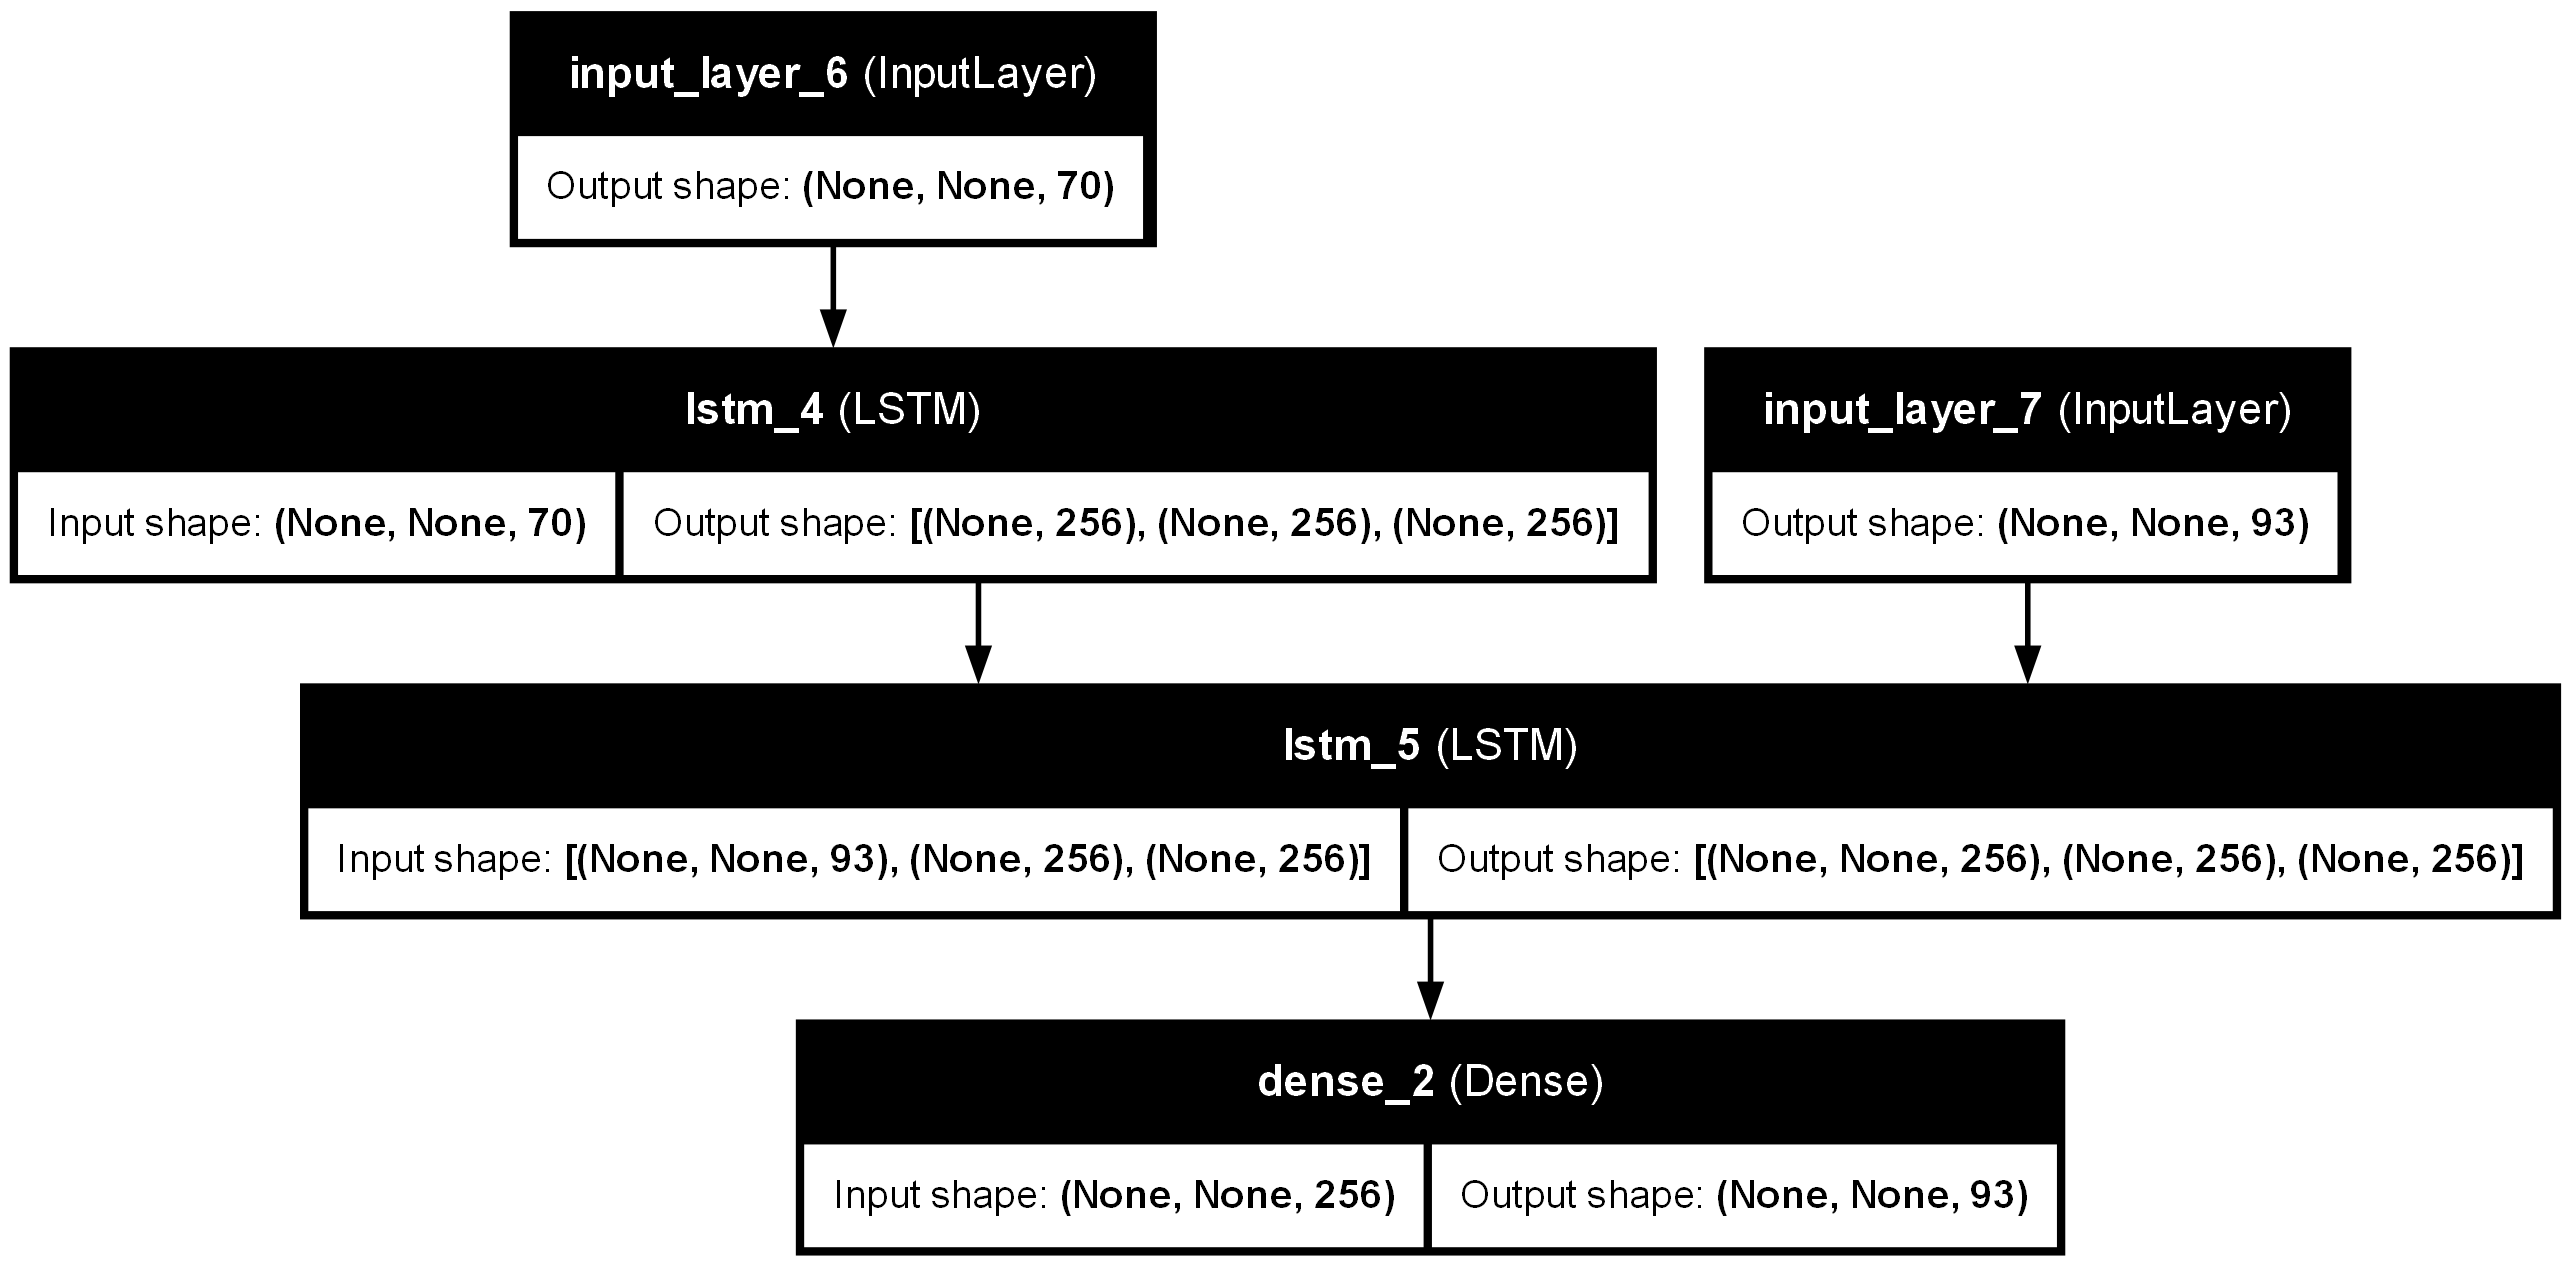

In [67]:
from keras.utils import plot_model

# Visualize the model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [68]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [69]:
# Run training
model.fit([encoder_input_data, decoder_input_data],
          decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - accuracy: 0.6677 - loss: 1.8881 - val_accuracy: 0.6824 - val_loss: 1.3679
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.7236 - loss: 1.1318 - val_accuracy: 0.6960 - val_loss: 1.1364
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - accuracy: 0.7309 - loss: 1.0288 - val_accuracy: 0.6997 - val_loss: 1.1253
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.7369 - loss: 0.9649 - val_accuracy: 0.7078 - val_loss: 1.0375
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.7468 - loss: 0.9123 - val_accuracy: 0.7215 - val_loss: 0.9861
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - accuracy: 0.7615 - loss: 0.8642 - val_accuracy: 0.7332 - val_loss: 0.9357
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.7762 - loss: 0.8030 - val_accuracy: 0.7523 - val_loss: 0.8766
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.7879 - loss: 0.7474 - 

In [71]:
# Save model
model.save('seq2seq.keras')

In [72]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states.

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

In [73]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [74]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [79]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=0)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [85]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-
Input sentence: Go.
Decoded sentence: Pour un !

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
-
Input sentence: Hi.
Decoded sentence: Pourons !

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
-
Input sentence: Run!
Decoded sentence: Pour somment bon reur !

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
-
Input sentence: Run!
Decoded sentence: Pour somment bon reur !

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
-
Input sentence: Who?
Decoded sentence: Qui que l'est en train de reprer tu tes portses.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
-
Input sentence: Wow!
Decoded sentence: Êtes-vous pleuré ?

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
-
Input sentence: Fire!
Decoded sentence: Laisse-toi d'en aller !

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
-
Input sentence: Help!
Decoded sentence: Laisse-toi d'en aller !

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
-
Input sentence: Jump.
Decoded sentence: Va chez moi.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
-
Input sentence: Stop!
Decoded sentence: Re

In [87]:
def translate_to_french(input_text):
    # Preprocess the input text
    input_text= input_text[:max_encoder_seq_length]
    input_seq = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
    for t, char in enumerate(input_text):
        if char in input_token_index:
            input_seq[0, t, input_token_index[char]] = 1.
    input_seq[0, t + 1:, input_token_index[' ']] = 1.

    # Generate the translation
    translated_sentence = decode_sequence(input_seq)
    return translated_sentence

In [92]:
test_set= input_texts[:10]
np.random.shuffle(test_set)
for i in test_set:
    translation= translate_to_french(i)
    print(i, "-->", translation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Run! --> Pour somment bon reur !

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Jump. --> Va chez moi.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Hi. --> Pourons !

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Go. --> Pour un !

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Help! --> Laisse-toi d'en aller !

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Wow! --> Êtes-vous pleuré ?

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Run! --> Pour somment bon reur !

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Fire! --> Laisse-toi d'en aller !

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Stop! --> Regarde-le.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Who? --> Qui que l'est en train de reprer tu tes portses.



## Train over the whole data in batches

In [20]:
def data_generator(input_texts, target_texts, batch_size):
    """Yield batches of input and target texts."""
    num_samples = len(input_texts)
    while True:
        for offset in range(0, num_samples, batch_size):
            # Get the batch inputs
            batch_input_texts = input_texts[offset:offset + batch_size]
            batch_target_texts = target_texts[offset:offset + batch_size]
            
            # Initialize the batch data arrays
            encoder_input_data = np.zeros(
                (len(batch_input_texts), max_encoder_seq_length, num_encoder_tokens),
                dtype='float32'
            )
            decoder_input_data = np.zeros(
                (len(batch_target_texts), max_decoder_seq_length, num_decoder_tokens),
                dtype='float32'
            )
            decoder_target_data = np.zeros(
                (len(batch_target_texts), max_decoder_seq_length, num_decoder_tokens),
                dtype='float32'
            )
            
            # Fill the batch data arrays
            for i, (input_text, target_text) in enumerate(zip(batch_input_texts, batch_target_texts)):
                for t, char in enumerate(input_text):
                    encoder_input_data[i, t, input_token_index[char]] = 1.
                for t, char in enumerate(target_text):
                    decoder_input_data[i, t, target_token_index[char]] = 1.
                    if t > 0:
                        decoder_target_data[i, t - 1, target_token_index[char]] = 1.

            yield (encoder_input_data, decoder_input_data), decoder_target_data

In [21]:
def create_dataset(input_texts, target_texts, batch_size):
    """Create a tf.data.Dataset from the generator."""
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(input_texts, target_texts, batch_size),
        output_signature=(
            (
                tf.TensorSpec(shape=(None, max_encoder_seq_length, num_encoder_tokens), dtype=tf.float32),
                tf.TensorSpec(shape=(None, max_decoder_seq_length, num_decoder_tokens), dtype=tf.float32)
            ),
            tf.TensorSpec(shape=(None, max_decoder_seq_length, num_decoder_tokens), dtype=tf.float32)
        )
    )
    return dataset

In [22]:
# Example usage during training
batch_size = 64
epochs = 100

dataset = create_dataset(input_texts, target_texts, batch_size)

model.fit(
    dataset,
    steps_per_epoch=len(input_texts) // batch_size,
    epochs=epochs
)

model.save('seq2seq_1.keras')